In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
df = pd.read_csv('G:/Nihal/train.csv')
df['ID'] = df['ID'].apply(lambda x: os.path.join('G:/Nihal/Train', x))
df.head(10)

,ID,Class
0,G:/Nihal/Train\377.jpg,MIDDLE
1,G:/Nihal/Train\17814.jpg,YOUNG
2,G:/Nihal/Train\21283.jpg,MIDDLE
3,G:/Nihal/Train\16496.jpg,YOUNG
4,G:/Nihal/Train\4487.jpg,MIDDLE
5,G:/Nihal/Train\6283.jpg,MIDDLE
6,G:/Nihal/Train\23495.jpg,YOUNG
7,G:/Nihal/Train\7100.jpg,YOUNG
8,G:/Nihal/Train\6028.jpg,YOUNG
9,G:/Nihal/Train\22617.jpg,OLD


In [3]:
null_values = df.isnull().sum()
null_table = pd.DataFrame({'Column': null_values.index, 'Null Count': null_values.values})
print("\nNull Values :")
print(null_table)


Null Values :
  Column  Null Count
0     ID           0
1  Class           0


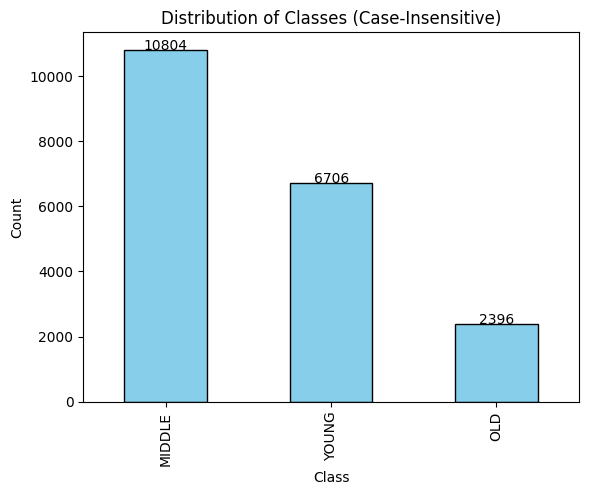

In [4]:
df['Class'] = df['Class'].str.upper()

class_counts = df['Class'].value_counts()

ax = class_counts.plot(kind='bar', color='skyblue', edgecolor='black')


plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes (Case-Insensitive)')


for i, v in enumerate(class_counts):
    ax.text(i, v + 0.1, str(v), color='black', ha='center')


plt.show()

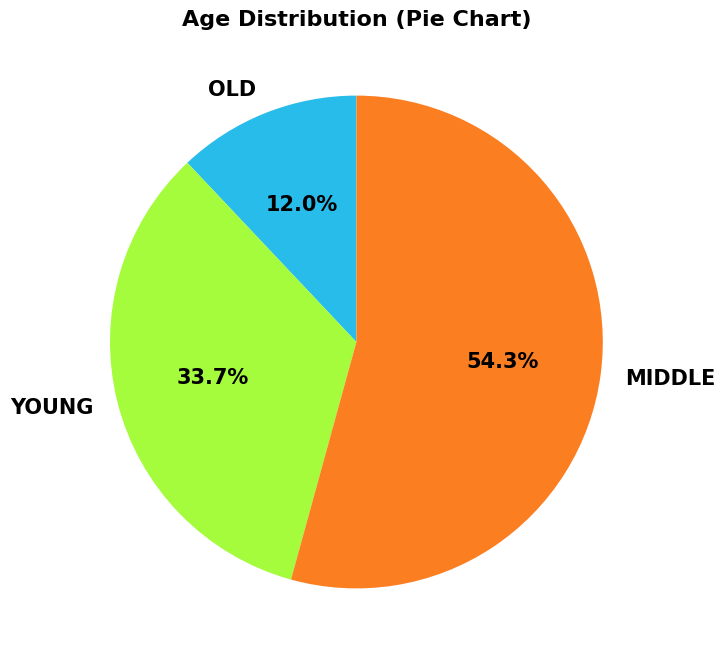

In [5]:
diagnoses = df['Class'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)

diagnosis_counts = diagnoses.value_counts().sort_values(ascending=True)


colors = sns.color_palette("turbo", n_colors=len(diagnosis_counts))


plt.figure(figsize=(8, 8))
plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct=lambda p: '{:.1f}%'.format(p),
        textprops={'weight': 'bold', 'fontsize': 15}, colors=colors, startangle=90)
plt.title("Age Distribution (Pie Chart)", fontsize=16, fontweight='bold')

plt.show()

In [6]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='ID',
    y_col='Class',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224))

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='ID',
    y_col='Class',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224,224))

Found 15925 validated image filenames belonging to 3 classes.
Found 3981 validated image filenames belonging to 3 classes.


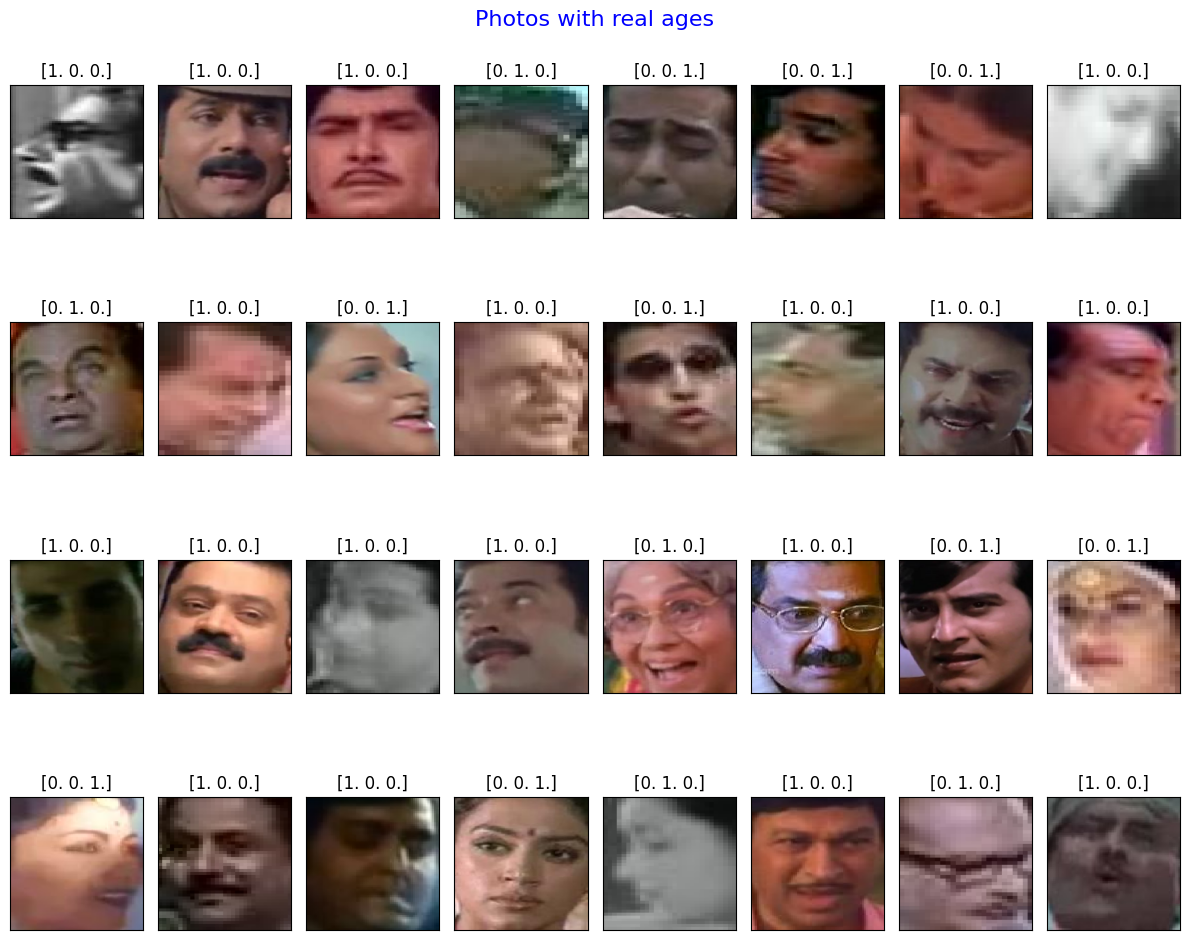

In [7]:
features, target = next(train_generator)

# displaying 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import AUC, Precision, Recall,F1Score
import tensorflow_addons as tfa

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # For 3 age categories
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', AUC(), Precision(), Recall(),tfa.metrics.F1Score(num_classes=3, average='macro')])


C:\Users\antuh\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\antuh\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint('model_wts', verbose=1, save_best_only=True)]

history_model = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10


498/498 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.6233 - auc_1: 0.8016 - precision_1: 0.6564 - recall_1: 0.5331 - f1_score: 0.4285
Epoch 1: val_loss improved from inf to 0.79931, saving model to model_wts
INFO:tensorflow:Assets written to: model_wts\assets


INFO:tensorflow:Assets written to: model_wts\assets


498/498 [==============================] - 772s 2s/step - loss: 0.8376 - accuracy: 0.6233 - auc_1: 0.8016 - precision_1: 0.6564 - recall_1: 0.5331 - f1_score: 0.4285 - val_loss: 0.7993 - val_accuracy: 0.6328 - val_auc_1: 0.8211 - val_precision_1: 0.6625 - val_recall_1: 0.5785 - val_f1_score: 0.4463
Epoch 2/10
498/498 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6791 - auc_1: 0.8509 - precision_1: 0.7153 - recall_1: 0.6113 - f1_score: 0.5332
Epoch 2: val_loss improved from 0.79931 to 0.70800, saving model to model_wts
INFO:tensorflow:Assets written to: model_wts\assets


INFO:tensorflow:Assets written to: model_wts\assets


498/498 [==============================] - 593s 1s/step - loss: 0.7335 - accuracy: 0.6791 - auc_1: 0.8509 - precision_1: 0.7153 - recall_1: 0.6113 - f1_score: 0.5332 - val_loss: 0.7080 - val_accuracy: 0.6935 - val_auc_1: 0.8617 - val_precision_1: 0.7111 - val_recall_1: 0.6529 - val_f1_score: 0.5462
Epoch 3/10
498/498 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.7155 - auc_1: 0.8812 - precision_1: 0.7453 - recall_1: 0.6688 - f1_score: 0.6213
Epoch 3: val_loss did not improve from 0.70800
498/498 [==============================] - 691s 1s/step - loss: 0.6573 - accuracy: 0.7155 - auc_1: 0.8812 - precision_1: 0.7453 - recall_1: 0.6688 - f1_score: 0.6213 - val_loss: 0.7266 - val_accuracy: 0.6938 - val_auc_1: 0.8617 - val_precision_1: 0.7116 - val_recall_1: 0.6687 - val_f1_score: 0.5593
Epoch 4/10
498/498 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7578 - auc_1: 0.9088 - precision_1: 0.7815 - recall_1: 0.7233 - f1_score: 0.6894
Epoch 4: 

INFO:tensorflow:Assets written to: model_wts\assets


498/498 [==============================] - 795s 2s/step - loss: 0.5770 - accuracy: 0.7578 - auc_1: 0.9088 - precision_1: 0.7815 - recall_1: 0.7233 - f1_score: 0.6894 - val_loss: 0.6589 - val_accuracy: 0.7234 - val_auc_1: 0.8821 - val_precision_1: 0.7547 - val_recall_1: 0.6677 - val_f1_score: 0.6660
Epoch 5/10
498/498 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7946 - auc_1: 0.9327 - precision_1: 0.8132 - recall_1: 0.7689 - f1_score: 0.7422
Epoch 5: val_loss did not improve from 0.65888
498/498 [==============================] - 758s 2s/step - loss: 0.4947 - accuracy: 0.7946 - auc_1: 0.9327 - precision_1: 0.8132 - recall_1: 0.7689 - f1_score: 0.7422 - val_loss: 0.6636 - val_accuracy: 0.7307 - val_auc_1: 0.8877 - val_precision_1: 0.7466 - val_recall_1: 0.7084 - val_f1_score: 0.6409
Epoch 6/10
498/498 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8430 - auc_1: 0.9578 - precision_1: 0.8560 - recall_1: 0.8266 - f1_score: 0.8087
Epoch 6: 

In [13]:
train_loss = history_model.history['loss']
val_loss = history_model.history['val_loss']
train_accuracy = history_model.history['accuracy']
val_accuracy = history_model.history['val_accuracy']
train_auc = history_model.history['auc_1']
val_auc = history_model.history['val_auc_1']
train_precision = history_model.history['precision_1']
val_precision = history_model.history['val_precision_1']
train_recall = history_model.history['recall_1']
val_recall = history_model.history['val_recall_1']

In [14]:
# Number of epochs
epochs = range(1, len(train_loss) + 1)

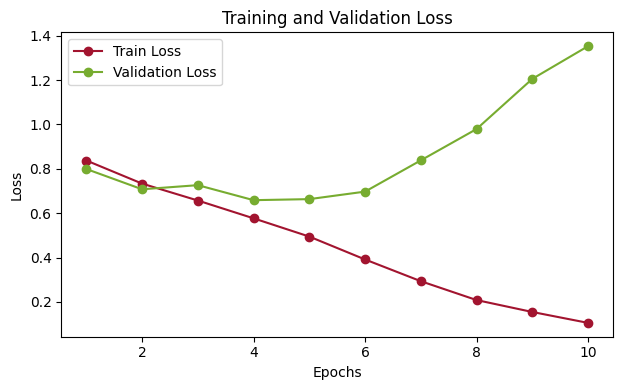

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', label='Train Loss', color='#A2142F')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color='#77AC30')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()


plt.show()

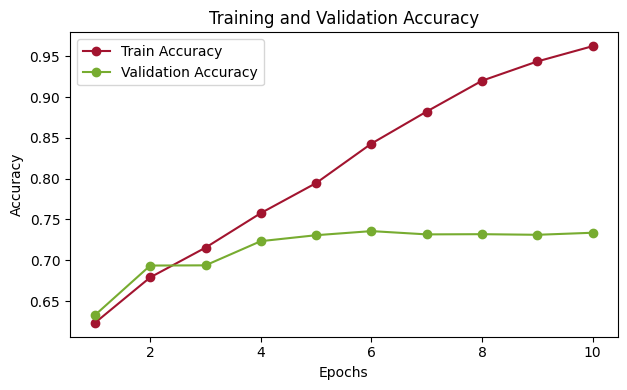

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'o-', label='Train Accuracy', color='#A2142F')
plt.plot(epochs, val_accuracy, 'o-', label='Validation Accuracy', color='#77AC30')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.tight_layout()


plt.show()

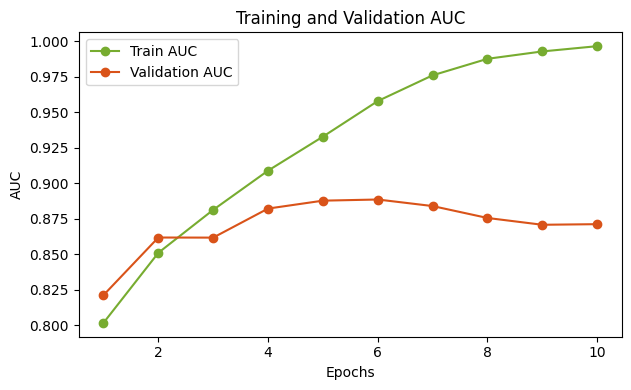

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_auc, 'o-', label='Train AUC', color='#77AC30')
plt.plot(epochs, val_auc, 'o-', label='Validation AUC', color='#D95319')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()


plt.show()

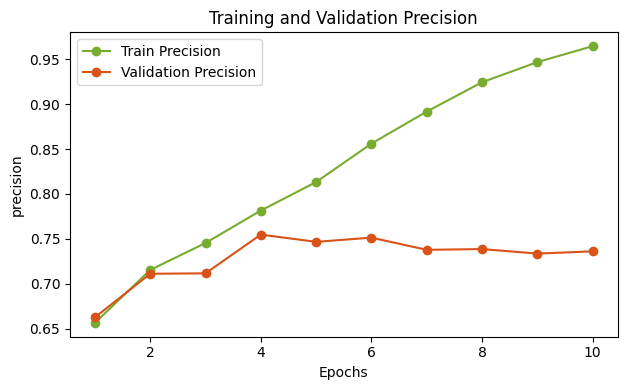

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_precision, 'o-', label='Train Precision', color='#77AC30')
plt.plot(epochs, val_precision, 'o-', label='Validation Precision', color='#D95319')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.title('Training and Validation Precision')
plt.legend()

plt.tight_layout()


plt.show()

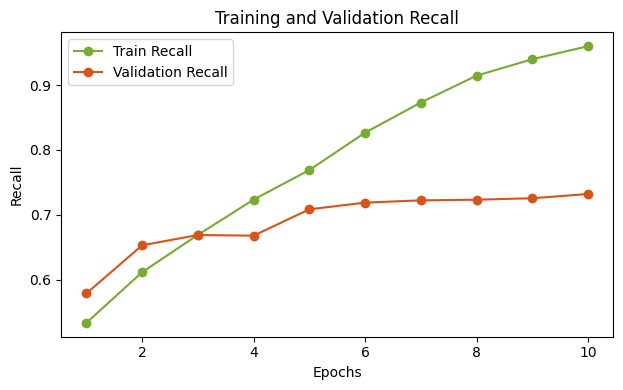

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_recall, 'o-', label='Train Recall', color='#77AC30')
plt.plot(epochs, val_recall, 'o-', label='Validation Recall', color='#D95319')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()

plt.tight_layout()


plt.show()

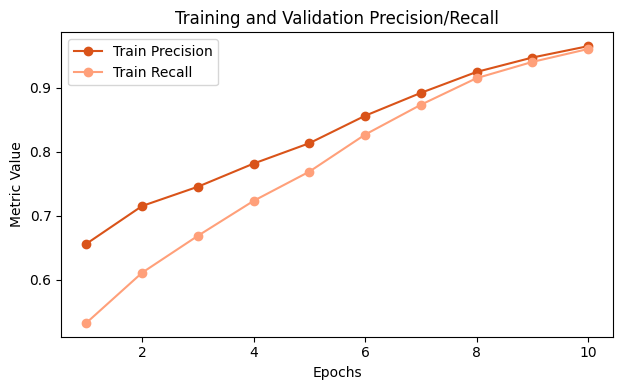

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_precision, 'o-', label='Train Precision', color='#D95319')

plt.plot(epochs, train_recall, 'o-', label='Train Recall', color='#FFA07A')

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Training and Validation Precision/Recall')
plt.legend()

plt.tight_layout()

plt.show()

In [4]:
model.save('age_prediction_m.h5')


NameError: name 'model' is not defined

### Anvil

In [2]:
import anvil.server
import tensorflow as tf
from PIL import Image
import numpy as np
import io

anvil.server.connect("server_3I7LBOCFH2HPOVO7S6TT2J7S-UBOJBJU7HA5BEJWJ")


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [3]:
model = tf.keras.models.load_model('age_prediction_m.h5') 


OSError: No file or directory found at age_prediction_m.h5

In [ ]:
def transform_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = image.resize((224, 224))  
    image_array = np.array(image) / 255.0  # Normalize the image
    return np.expand_dims(image_array, axis=0)


In [ ]:
@anvil.server.callable
def predict_age(image_file):
    image_bytes = image_file.get_bytes()
    image_array = transform_image(image_bytes)
    predictions = model.predict(image_array)
    predicted_age_group_index = np.argmax(predictions, axis=1)[0]  

    # Define a mapping from index to label
    age_group_labels = {2: "Young", 0: "Middle", 1: "Old"}

    
    predicted_age_group_label = age_group_labels[predicted_age_group_index]

    return predicted_age_group_label





In [ ]:
anvil.server.wait_forever()


1/1 [==============================] - 0s 45ms/step
